# Oil Seep Detection 

In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import cv2
import os

Using TensorFlow backend.


## Explore Dataset

In [2]:
def plot_image_mask(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Seep Image")

    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

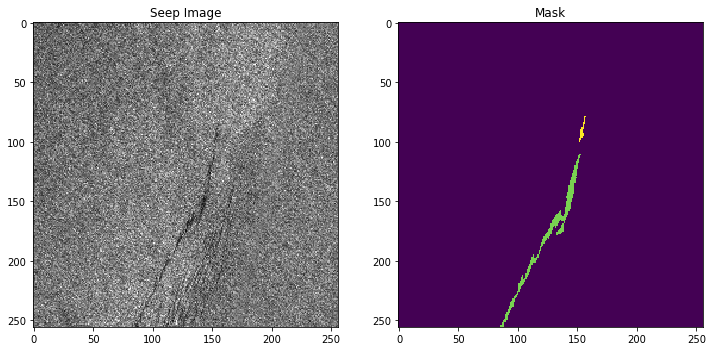

In [3]:
idx = 1

img_path = "seep_detection/images/train_images_256/"
mask_path = "seep_detection/masks/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
    images.append((plt.imread(img_path + filename)))
    masks.append(plt.imread(mask_path + filename))

plot_image_mask(images[idx], masks[idx])

In [4]:
print("Dataset Size: {}".format(len(images)))

Dataset Size: 790


## Preprocess Data 

In [5]:
images_process = np.expand_dims(images, -1) / 255
masks_onehot = to_categorical(masks)

X_train, X_test, y_train, y_test = train_test_split(images_process, masks_onehot, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [6]:
batch_size = 128

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

/Users/ricardodiaz/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (632, 256, 256, 8) (8 channels).
  ' channels).')
/Users/ricardodiaz/anaconda3/envs/py37/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (632, 256, 256, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


## Validate Preprocessing

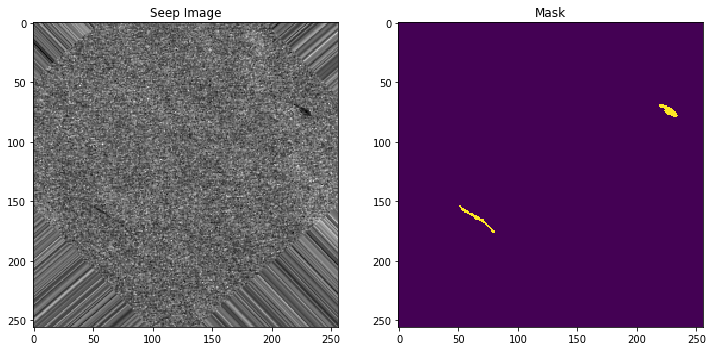

In [7]:
for img, mask in train_generator:
    mask_test = np.argmax(mask[0], -1)
    img_test = img[0][:,:,0]
    break

plot_image_mask(img_test, mask_test)

## Modeling

In [9]:
from models import *

model = get_unet()

model.compile(optimizer=Adam(lr=0.01), loss="categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

## Training

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    validation_steps=1,
    epochs=50)

Epoch 1/50
4/4 [==============================] - 128s 32s/step - loss: 7.6419 - acc: 0.0757 - val_loss: 14.0520 - val_acc: 0.1051
Epoch 2/50
